In [1]:
#Import the necessary methods from tweepy library
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import tweepy
import csv
import pandas as pd
import sys
import os
import sqlalchemy
import datetime

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

from nltk.tokenize import RegexpTokenizer

In [2]:
# defining a new directory name where we will store the database and the images
path_to_directory = 'BigData - Algorithms and Platforms'

In [3]:
# creating the new directory
try :
    os.stat(path_to_directory) # checking if the directory exists
except :
    os.mkdir(path_to_directory) # creating it

In [4]:
# creating a sqlite database engine
engine = sqlalchemy.create_engine("sqlite:///"+ path_to_directory + "/bigdata_algo.db")
# creating the database
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()

In [5]:
from sqlalchemy import Column, Integer, Float, Date
from sqlalchemy.orm import sessionmaker

# defining the table Tweet and its attributes
class Tweet(Base):
    __tablename__ = 'Tweet'
    tweet_id = Column(Integer, primary_key=True, nullable=False) 
    tweet_user_id = Column(Integer)
    tweet_creation_date = Column(Date)
    tweet_text = Column(CHAR)
    
    def __init__(self, tweet_id, tweet_user_id, tweet_creation_date, tweet_text):
        self.tweet_id = tweet_id
        self.tweet_user_id = tweet_user_id
        self.tweet_creation_date = tweet_creation_date
        self.tweet_text = tweet_text

# defining the table User and its attributes
class User(Base):
    __tablename__ = 'User'
    #__table_args__ = {'sqlite_autoincrement': True}
    user_id = Column(Integer, primary_key=True, nullable=False) 
    user_num_followers = Column(Integer)
    user_num_friends = Column(Integer)
    user_creation_date = Column(Date)
        
    def __init__(self, user_id, user_num_followers, user_num_friends, user_creation_date):
        self.user_id = user_id
        self.user_num_followers = user_num_followers
        self.user_num_friends = user_num_friends
        self.user_creation_date = user_creation_date

# creating the tables within the database
Base.metadata.create_all(engine)

In [6]:
# opening an sqlite session
session = sessionmaker()
session.configure(bind=engine)
s = session()

In [7]:
# defining authorisation tokens and keys to access twitter API
consumer_key = '****'
consumer_secret = '****'
access_token = '****-****'
access_token_secret = '****'

In [8]:
# creating access authorisation
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

In [9]:
# defining a custom stream listener
class CustomStreamListener(tweepy.StreamListener):
    
    def __init__(self, count = None, verbose = 1, 
                 parent = None):
        """
        creating a CustomStreamListener object 
        ---
        count : if None the stream will never stop, if 1, sets the number of streamed tweets to count
        verbose : if 0, does not display anything, if 1 displays tweet texts as it comes, 
                  if more display remaining count every verbose iterations
        """
        # instantiating the superclass
        super(CustomStreamListener, self).__init__(parent)
        # setting other attributes
        self.count = count
        self.verbose = verbose
        self.user_ids = []
        self.tweet_ids = []
        
    def on_status(self, status):
        """
        stores tweets in the database
        """
        # handling display options
        if self.verbose ==1:
            print(status.author.screen_name,'|', status.created_at,'|', status.text)
        else :
            if self.verbose >1:
                if self.count%self.verbose==0:
                    print(self.count)
        
        # as tweet_id is a primary key of Tweet table, we need to make sure that there will be no duplicates
        if status.id not in self.tweet_ids:
            # instantiating the Tweet class
            tweet_data = {'tweet_id':status.id, 'tweet_user_id':status.author.id, 
                          'tweet_creation_date':status.created_at, 'tweet_text':status.text}
            tweet = Tweet(**tweet_data)
            # adding the tweet data to the database
            s.add(tweet) 
            # adding the tweet_id to the list of already taken care of tweet_ids
            self.tweet_ids.append(status.id)

        # as user_id is the primary key of User table, we need to make sure that there will be no duplicates  
        if status.author.id not in self.user_ids:
            # instantiating the User class
            user_data = {'user_id':status.author.id, 
                       'user_num_followers':status.author.followers_count,
                       'user_num_friends':status.author.friends_count,
                       'user_creation_date':status.author.created_at}
            user = User(**user_data)
            # adding the user data to the database
            s.add(user)
            # adding the user_id to the list of already taken care of user_ids
            self.user_ids.append(status.author.id)
        
        # handling the count of remaining tweets to catch 
        if self.count != None:
            self.count -=1
            # stopping the stream listener if there is no tweet left to acquire
            if self.count == 0:
                return False
        
    def on_error(self, status_code):
        """
        prints the error code if an error happens when the stream is running
        ---
        allows us not to kill the stream if an error happens
        """
        print('Encountered error with status code:', status_code)
        return True # Don't kill the stream

In [10]:
# instantiating the listener
listener = CustomStreamListener(count = 1000000, verbose = 1000)

In [ ]:
# getting twitter data
# for large number of tweets, we may encounter a TimeOut error
# therefore, we need to find a way to enforce it to continue
# this is what this while/try/except block will do
while listener.count > 0:
    try :
        streamingAPI = tweepy.streaming.Stream(auth, listener)
        streamingAPI.filter(track=['trump'])
    except : 
        print('Timed out at ', datetime.datetime.now())
        print('Counter : ',listener.count)
        continue

In [12]:
# commiting changes to the database
try :
    s.commit()
except :
    # takes care of errors
    s.rollback()
finally :
    # closing the sqlite session
    s.close()

In [13]:
# querying all tweets within the Tweet table
query = s.query(Tweet)

In [14]:
# getting the text of the tweets in a dataframe
df_tweet = pd.DataFrame({'tweet_text': [row.tweet_text for row in query.all()]})
print(df_tweet.head())

                                          tweet_text
0  RT @NWPinPDX: Donald J Trump and #SarahHuckabe...
1  RT @kylegriffin1: Progressive group Not One Pe...
2  RT @JasonSPeters: 🔴President Donald J. Trump  ...
3  RT @thinkprogress: Trump is now suggesting the...
4  RT @_Makada_: Liberals are calling President T...


In [15]:
# tokenizing words on punctuation
tokenizer = RegexpTokenizer(r'\w+')
df_tweet['text_array'] = df_tweet['tweet_text'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [17]:
# defining a list of stop words that we are going to get rid off
# this list was given to us by Fragkiskos ALLIAROS, professor of ML in the master
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
                 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
                 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
                 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
                 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
                 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
                 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
                 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
                 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
                 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
                 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'rt']+\
['https', 'co', 'day', 'says', 'would', 'think', 'm', 'know', 'one', 'thank', 'doesn', 'get', 'time', 'amp', 'like', 're', 'could']

In [18]:
# getting rid off the stop words and storing the remaining, the important ones, in a new column
df_tweet['important'] = df_tweet['text_array'].apply(lambda x: [y for y in x if y not in stopwords])

In [19]:
# creating a frequency array of the important words in order to select only the 50 more present
frequencies ={}
for row in df_tweet['important']:
    for word in row:
        if word in frequencies.keys():
            frequencies[word] +=1
        else :
            frequencies[word] = 1
frequencies = pd.Series(frequencies).sort_values(ascending=False) 

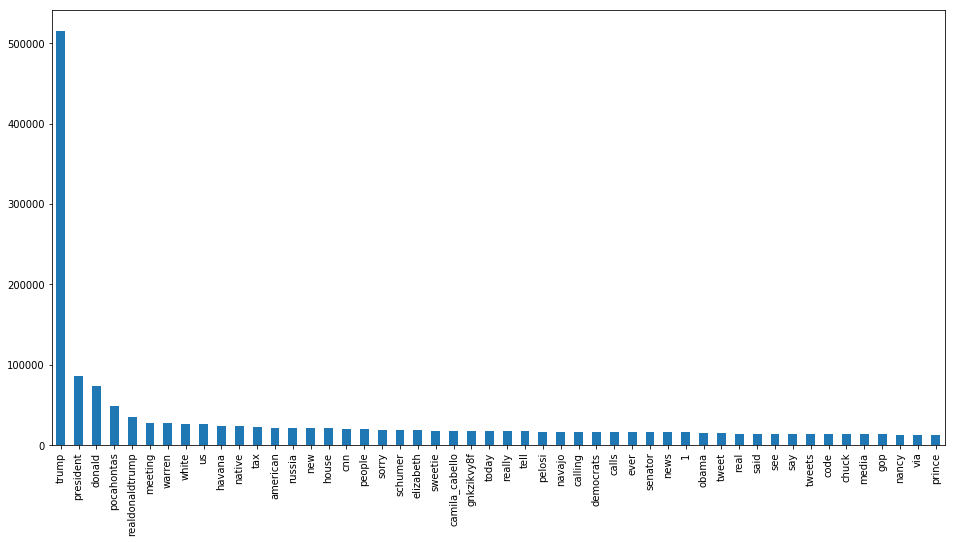

In [20]:
# plotting the 50 most common words and their number of appearances and saving the plot
frequencies[:50].plot(kind = 'bar', figsize = (16,8))
plt.savefig(path_to_directory + '/frequency.png')
plt.show()

In [21]:
# keeping only the 50 most frequent words 
most_frequent = list(frequencies[:50].keys())

In [22]:
# creating a column in our dataframe with only the most frequent words
df_tweet['most_important_array'] = df_tweet['important'].apply(lambda x: [y for y in x if y in most_frequent])

In [23]:
# we create edges, meaning tuples of words, if those two important and frequent words appear in the same tweet
# and storing it as a list of tuples in our dataframe
df_tweet['edges'] = df_tweet['most_important_array'].apply(lambda x: [(y,z) for y in x for z in x if y!=z])

In [24]:
# removing duplicates edges
df_tweet['edges'] = df_tweet['edges'].apply(lambda x: x[:int(len(x)/2)])

In [25]:
# creating a graph object
tweet_graph = nx.graph.Graph()

In [26]:
# adding the 50 most frequent words as nodes of our graph
for word in most_frequent:
    tweet_graph.add_node(word)

In [27]:
# computing the edge frequencies
edge_frequencies = {}
for row in df_tweet['edges']:
    for edge in row:
        if edge in edge_frequencies.keys():
            edge_frequencies[edge]+=1
        else :
            edge_frequencies[edge]=1
# computing the relative edge frequencies:
# relative edge frequency = edge frequency / max(edge frequency)
weighted_edges = []
maximum_edge_freq = max(edge_frequencies.values())
for edge in edge_frequencies.keys():
    x,y = edge
    weighted_edges.append((x, y, edge_frequencies[edge]/maximum_edge_freq)) 

In [28]:
# adding the edges to the graph 
for edge in edge_frequencies:
    tweet_graph.add_weighted_edges_from(weighted_edges)

In [29]:
# creating positions to visualize the graph
pos_circular=nx.circular_layout(tweet_graph)
pos_spring = nx.spring_layout(tweet_graph)

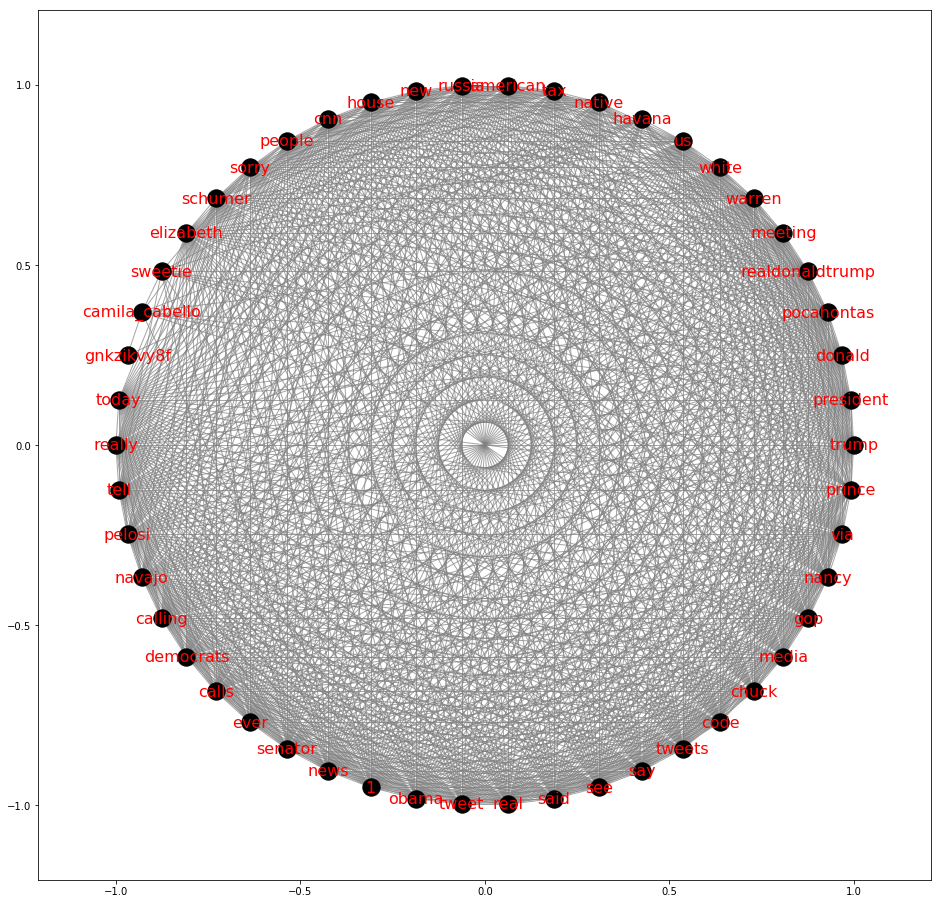

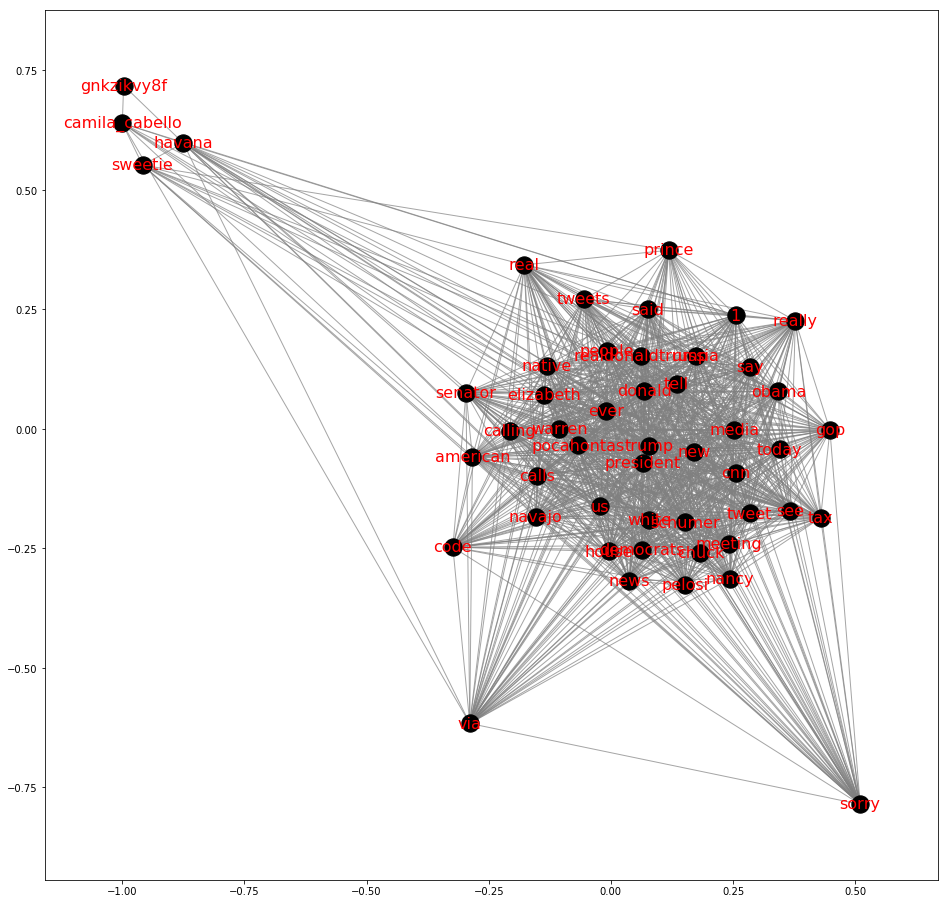

In [30]:
# Creating a circular graph plot with non-weighted edges transparency
plt.figure(figsize=(16,16))
nx.draw_networkx_nodes(tweet_graph, pos_circular, node_color = 'black')
nx.draw_networkx_edges(tweet_graph, pos_circular, alpha = .7, edge_color = 'grey')
nx.draw_networkx_labels(tweet_graph, pos_circular, font_color  = 'red', font_size = 16)
plt.savefig(path_to_directory + '/trump_tweets_circular.png')
plt.show()
# Creating a non-circular graph plot with non-weighted edges transparency
plt.figure(figsize=(16,16))
nx.draw_networkx_nodes(tweet_graph, pos_spring, node_color = 'black')
nx.draw_networkx_edges(tweet_graph, pos_spring, alpha = .7, edge_color = 'grey')
nx.draw_networkx_labels(tweet_graph, pos_spring, font_color  = 'red', font_size = 16)
plt.savefig(path_to_directory + '/trump_tweets_spring.png')
plt.show()

In [31]:
# creating a dictionnary of edges with weight between 0 and 1 as keys and a list of edges that all share the same weight range
weight_edges_tuples_sup ={str(weight):[(u,v) for (u,v,w) in weighted_edges if w>weight-.01 and w<=weight] for weight in np.array(range(1,101))/100}
weight_edges_tuples_inf ={str(weight):[(u,v) for (u,v,w) in weighted_edges if w>weight and w<=weight+.01] for weight in np.array(range(0,100))/100}

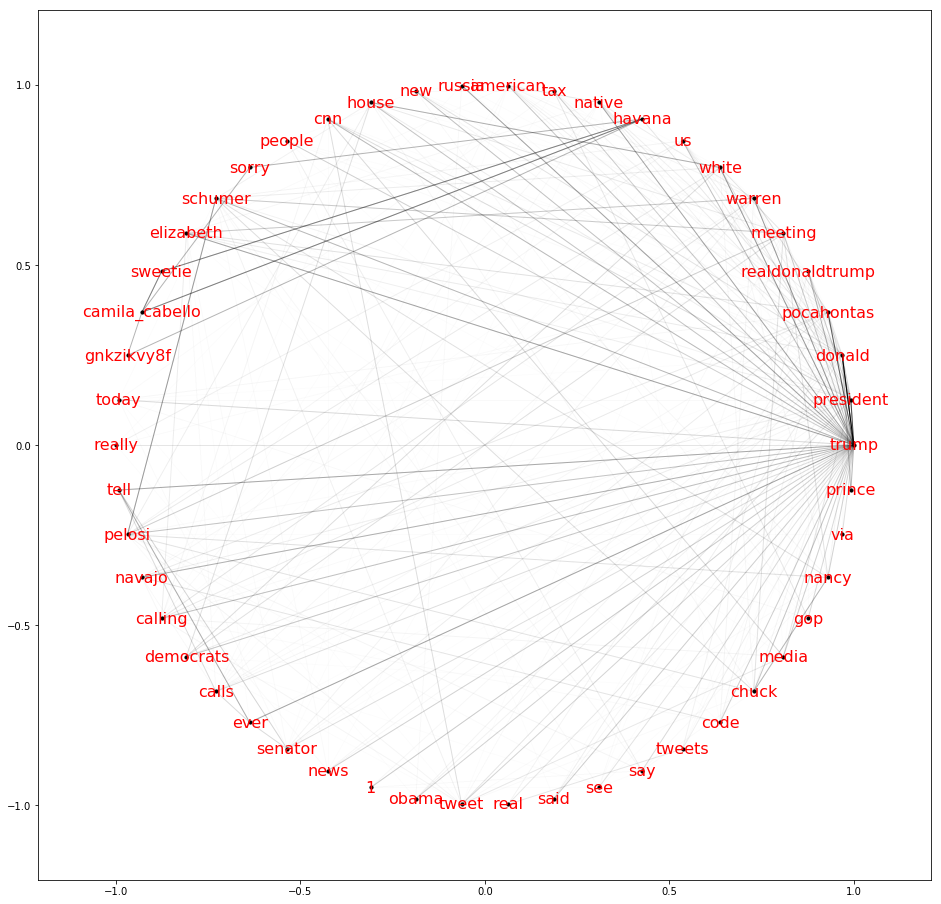

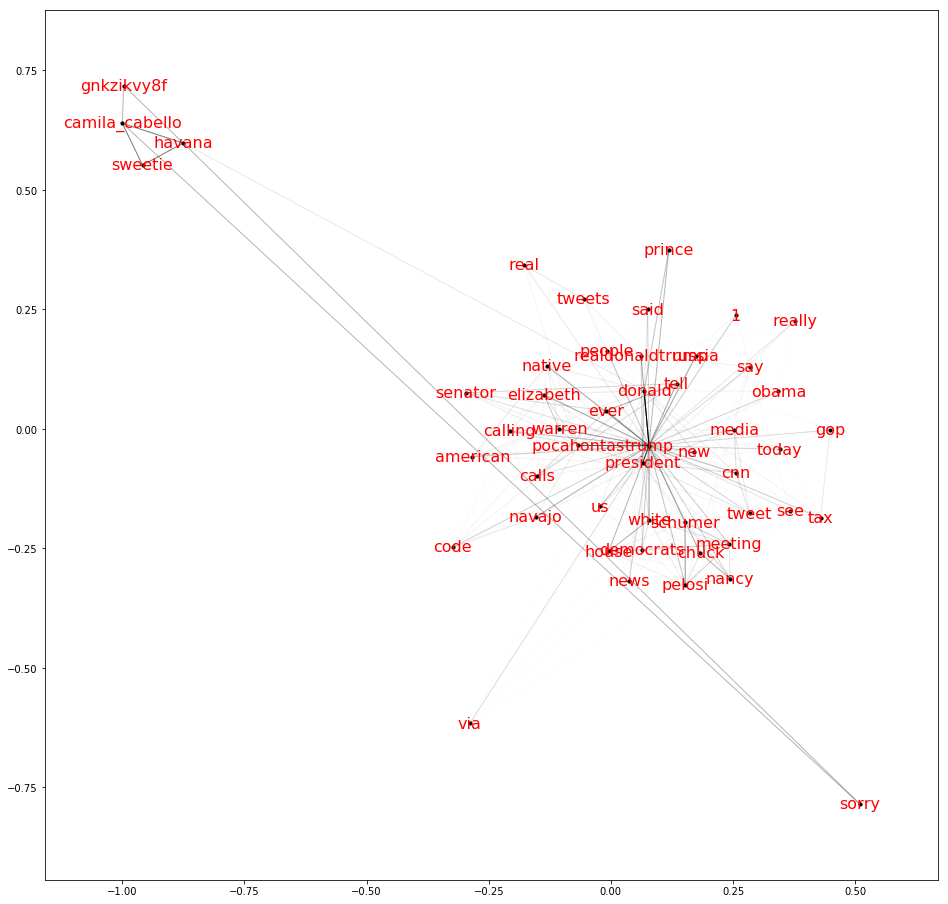

In [32]:
# Creating a circular graph plot with weighted edges transparency
plt.figure(figsize=(16,16))
nx.draw_networkx_nodes(tweet_graph, pos_circular, node_color = 'black', node_size = 10)
for key in weight_edges_tuples_inf.keys():
    nx.draw_networkx_edges(tweet_graph, pos_circular, edgelist=weight_edges_tuples_inf[key], alpha = float(key), edge_color = 'k')
nx.draw_networkx_labels(tweet_graph, pos_circular, font_color  = 'red', font_size = 16)
plt.savefig(path_to_directory + '/trump_tweets_weighted_circular.png')
plt.show()
# Creating a non-circular graph plot with weighted edges transparency
plt.figure(figsize=(16,16))
nx.draw_networkx_nodes(tweet_graph, pos_spring, node_color = 'black', node_size = 10)
for key in weight_edges_tuples_inf.keys():
    nx.draw_networkx_edges(tweet_graph, pos_spring, edgelist=weight_edges_tuples_inf[key], alpha = float(key), edge_color = 'k')
nx.draw_networkx_labels(tweet_graph, pos_spring, font_color  = 'red', font_size = 16)
plt.savefig(path_to_directory + '/trump_tweets_weighted_spring.png')
plt.show()